In [3]:
import sys
sys.path.append('../../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

import matplotlib.pyplot as plt

2024-09-05 19:19:44.209936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 19:19:44.209967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 19:19:44.211212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Get data ready

In [7]:
MOM6_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_'
#MOM6_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_'
L = 'all'
window_size=3

In [8]:
ML_data = datasets.MOM6_all_transformer('-', 'all', 
                                       input_channels = ['U_x', 'U_y', 
                                                         'V_x', 'V_y', 
                                                         'Sx', 'Sy',
                                                        'Lfilt'])

In [9]:
ML_data.read_datatree(MOM6_bucket, 
                      file_names='', # need this for file names in DG sim
                      keep_filt_scale=True, 
                      para_perp_out = True, 
                      eta_bottom=True,
                      large_filt=4,
                      H_mask=150,
                      sub_sample=True, 
                      window_size=window_size)

Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_50km.zarr
Out para perp
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_100km.zarr
Out para perp
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_200km.zarr
Out para perp
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_400km.zarr
Out para perp
Subsampling


In [5]:
ML_data.generate_test_train_batches(normalize=False, input_dims = {'Xn':window_size,'Yn':window_size})

Test and train batches split. Number of batches: 37-5


In [11]:
ML_data.datatree['100'].Time

<xarray.DataArray 'Time' (Time: 3600)> Size: 29kB
array([cftime.DatetimeJulian(1, 1, 11, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1, 1, 21, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1, 1, 31, 0, 0, 0, 0, has_year_zero=False), ...,
       cftime.DatetimeJulian(99, 7, 6, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(99, 7, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(99, 7, 26, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * Time     (Time) object 29kB 0001-01-11 00:00:00 ... 0099-07-26 00:00:00
    zl       float64 8B 1.036e+03

In [6]:
ML_data.ds_train

<xarray.Dataset> Size: 947MB
Dimensions:  (Xn: 3, Yn: 3, points: 2660040)
Coordinates:
    zl       float64 8B 1.036e+03
  * points   (points) object 21MB MultiIndex
  * Time     (points) object 21MB 0042-11-12 00:00:00 ... 0086-12-31 00:00:00
  * xh       (points) float64 21MB 16.83 14.52 16.94 9.24 ... 15.02 9.02 11.55
  * yh       (points) float64 21MB 35.55 42.0 35.64 35.45 ... 36.95 37.09 44.27
Dimensions without coordinates: Xn, Yn
Data variables:
    Sfnx     (Xn, Yn, points) float32 96MB 0.002682 -0.163 ... -0.04496 0.03779
    Sfny     (Xn, Yn, points) float32 96MB -0.004036 0.1321 ... 0.04439 -0.03498
    U_x      (Xn, Yn, points) float32 96MB 1.049e-09 5.359e-08 ... -8.719e-08
    U_y      (Xn, Yn, points) float32 96MB -7.428e-10 -9.006e-09 ... -3.37e-07
    V_x      (Xn, Yn, points) float32 96MB -6.35e-08 -7.089e-08 ... 1.696e-07
    V_y      (Xn, Yn, points) float32 96MB 1.124e-10 -6.001e-08 ... 1.008e-07
    Sx       (Xn, Yn, points) float32 96MB -4.084e-05 3.578e-05 ... -0.0002
    Sy       (Xn, Yn, points) float32 96MB 5.764e-05 0.0001946 ... 0.0005104
    Lfilt    (Xn, Yn, points) float32 96MB 100.0 400.0 200.0 ... 200.0 100.0

## Setup ML model

In [6]:
ANN_model = ML_classes.ANN(num_in =  (len(ML_data.input_channels) - 1)* ML_data.window_size**2 + 1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [40]:
regress_sys = ML_classes.RegressionSystem(ANN_model, local_norm=True)

## Train model

In [43]:
%%time
regress_sys.train_system_windowed(ML_data, 31, 1)

Train loss step 0:  0.17183016119776545 test loss: 0.12529688626527785
Train loss step 1:  0.11797607508865562 test loss: 0.10883321166038513
Train loss step 2:  0.10519066674483789 test loss: 0.09720859378576278
Train loss step 3:  0.0925267900566797 test loss: 0.08484051376581192
Train loss step 4:  0.08169520706743807 test loss: 0.07597437649965286
Train loss step 5:  0.07381380288987546 test loss: 0.0699607104063034
Train loss step 6:  0.06896803326703407 test loss: 0.06603179275989532
Train loss step 7:  0.06566912640590926 test loss: 0.06347460746765136
Train loss step 8:  0.06303964021640855 test loss: 0.060874085128307345
Train loss step 9:  0.060734725985172634 test loss: 0.058491005748510363
Train loss step 10:  0.05891599777985264 test loss: 0.05683438554406166
Train loss step 11:  0.05726536504320196 test loss: 0.055405568331480026
Train loss step 12:  0.05596902916157568 test loss: 0.05421810671687126
Train loss step 13:  0.054782596794334615 test loss: 0.05317027717828750

In [45]:
%%time
regress_sys.train_system_windowed(ML_data, 11, 1)

Train loss step 0:  0.04395745896004342 test loss: 0.043616943061351776
Train loss step 1:  0.04365152523324296 test loss: 0.04334046840667725
Train loss step 2:  0.04331479312197582 test loss: 0.04306191429495811
Train loss step 3:  0.04301939139495025 test loss: 0.042879479378461836
Train loss step 4:  0.04276829404202667 test loss: 0.04265912771224976
Train loss step 5:  0.042454350941084525 test loss: 0.04245894700288773
Train loss step 6:  0.04216887540108449 test loss: 0.04231158643960953
Train loss step 7:  0.0419133970060864 test loss: 0.04194685369729996
Train loss step 8:  0.041656424064893983 test loss: 0.04158417284488678
Train loss step 9:  0.04140638721150321 test loss: 0.041250114887952806
Train loss step 10:  0.041139159150220254 test loss: 0.040979339927434924
CPU times: user 11min 15s, sys: 1.22 s, total: 11min 16s
Wall time: 10min 53s


In [49]:
%%time
regress_sys.train_system_windowed(ML_data, 31, 1)

Train loss step 0:  0.040924588872774226 test loss: 0.040838387608528134
Train loss step 1:  0.04066380566439113 test loss: 0.04032733291387558
Train loss step 2:  0.040507294741031284 test loss: 0.0403082825243473
Train loss step 3:  0.040274763429487076 test loss: 0.04010099917650223
Train loss step 4:  0.04010776732418988 test loss: 0.03992174044251442
Train loss step 5:  0.03992179338191006 test loss: 0.039653020352125166
Train loss step 6:  0.03975039438621418 test loss: 0.039692173153162
Train loss step 7:  0.03951617944482211 test loss: 0.03927815034985542
Train loss step 8:  0.03942816805195164 test loss: 0.0391499862074852
Train loss step 9:  0.03928078902331558 test loss: 0.03896090537309647
Train loss step 10:  0.03915464143092568 test loss: 0.038828995823860166
Train loss step 11:  0.03903287548471142 test loss: 0.03870366737246513
Train loss step 12:  0.03893157235673956 test loss: 0.038566532731056216
Train loss step 13:  0.03883103381943058 test loss: 0.03844414725899696

(0.03, 0.3)

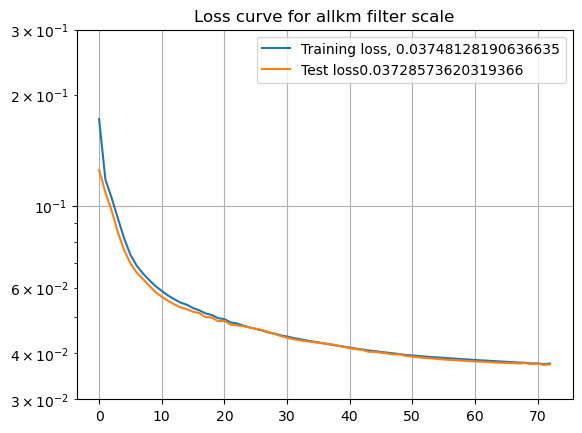

In [50]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.title('Loss curve for '+ L+ 'km filter scale')
plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim([0.03, .3])

#plt.savefig('figures/MOM6_'+L+'km_loss_curve_36_36.png')

In [51]:
# Save the checkpoint
CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/ckpts_all_MOM6_DG_window_3_local_norm_true_out_para_perp_Lfilt_in'
regress_sys.save_checkpoint(CKPT_DIR)

# Save model nc file
model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/' +'MOM6_DG_all_window_3_local_norm_true_out_para_perp_Lfilt_in'+'.nc'
regress_sys.save_weights_nc(model_nc)

In [14]:
ANN_model_large = ML_classes.ANN(shape=[36,36,2], num_in = len(ML_data.input_channels))

In [18]:
regress_sys_large = ML_classes.RegressionSystem(ANN_model_large, local_norm=True)

In [18]:
%%time
regress_sys_large.train_system(ML_data, 31, 1)

NameError: name 'regress_sys_large' is not defined

In [20]:
# Save the checkpoint
CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/ckpts_all_MOM6_P2L_window_1_local_norm_true_out_para_perp_size_36_36'
regress_sys.save_checkpoint(CKPT_DIR)

# Save model nc file
model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/' +'MOM6_P2L_all_window_1_local_norm_true_out_para_perp_size_36_36'+'.nc'
regress_sys.save_weights_nc(model_nc)